# Load library

In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
# DT
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# NB
from sklearn.naive_bayes import GaussianNB
# MLP
from sklearn.neural_network import MLPClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# Adafair
from AdaFair import AdaFair 
# Agarwal
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
# DIR
from disparate_impact_remover import DisparateImpactRemover
# LFR
from learning_fair_representations import LFR
# EOP
from eq_odds_postprocessing import EqOddsPostprocessing
# CEP
from calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-27 10:42:17.907837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 10:42:17.907857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

## Credit Scoring

In [2]:
#Credit scoring data
#https://www.kaggle.com/code/islombekdavronov/credit-scoring
#FinTech companies in Central Asia.
def load_credit_scoring():
    df = pd.read_csv('data/credit_scoring.csv')    
    protected_attribute = 'Sex'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'label'  
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    df = df.replace({'-':0})
    df['Score_point']=df['Score_point'].astype(float)
    
       
    #Label sex
    df['Sex']=["Female" if v == 2 else "Male" for v in df['Sex']]
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,1:length-1]
    y = df[class_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute,majority_group_name,minority_group_name

# Run experiment

In [3]:
def run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):    
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    
    # preprocessing
    if preprocessing_algorithm != '': 
        if preprocessing_algorithm == 'DIR':
            pre_model = DisparateImpactRemover(sensitive_attribute=protected_attribute)
        elif preprocessing_algorithm == 'LFR':
            privileged_groups = [{protected_attribute: 1.0}]
            unprivileged_groups = [{protected_attribute: 0.0}]
            pre_model = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        dataset_train_transf = pre_model.fit_transform(datasetTrain)
        dataset_test_transf = pre_model.transform(datasetTest)

        X_train_transf = dataset_train_transf.features
        y_train_transf = dataset_train_transf.labels.ravel()
        X_test_transf = dataset_test_transf.features
        y_test_transf= dataset_test_transf.labels.ravel()

        X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
        y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
        X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
        y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)
    
    # inprocessing
    if algorithm == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)  
    elif algorithm == 'NB': 
        model = GaussianNB()
    elif algorithm == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    elif algorithm == 'kNN':
        model = KNeighborsClassifier(n_neighbors=5)
    elif algorithm == 'Ada':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    elif algorithm == 'Agar':
        clf =  NB = GaussianNB()
        model = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    
    if preprocessing_algorithm != '':
        model.fit(X_train_transf, y_train_transf)
        y_predicts = model.predict(X_test_transf)
    else:
        model.fit(X_train,y_train)
        y_predicts = model.predict(X_test)

    # postprocessing
    if postprocessing_algorithm != '':
        privileged_groups = [{protected_attribute: 1.0}]
        unprivileged_groups = [{protected_attribute: 0.0}]
        if postprocessing_algorithm == 'EOP':
            post_model = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        if postprocessing_algorithm == 'CEP':
            post_model = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        
        y_test_predicts = model.predict(X_test)
        y_train_predicts = model.predict(X_train)

        X_train_predicts = X_train.copy()
        X_test_predicts = X_test.copy()

        X_train_predicts[y_train.name] = y_train_predicts
        X_test_predicts[y_train.name] = y_test_predicts
    
        dataset_train_true = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_train_predicts = BinaryLabelDataset(df=X_train_predicts, label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_test_predicts = BinaryLabelDataset(df=X_test_predicts, label_names=[y_test.name], protected_attribute_names=[protected_attribute])

        post_model.fit_predict(dataset_true=dataset_train_true, dataset_pred=dataset_train_predicts)
        dataset_predicts_transf = post_model.predict(dataset_test_predicts)
        data_predicts = dataset_predicts_transf.convert_to_dataframe()[0]
        y_predicts = data_predicts[y_test.name].astype(int)

    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    filename = '{}.{}.abroca.pdf'.format(dataset, preprocessing_algorithm+algorithm)
    #make predictions
    if postprocessing_algorithm == '':
        if preprocessing_algorithm:
            X_test['pred_proba'] = model.predict_proba(X_test_transf)[:,1:2]
        else:
            X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
        X_test['true_label'] = y_test
        df_test = X_test

        #Compute Abroca
        slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                            majority_protected_attr_val = 1, n_grid = 10000,
                            plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
        print("ABROCA:",slice)
        plt.clf()
    plt.clf()

In [4]:
#Main function
def run_eval(dataset, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):
    if dataset == 'credit-approval':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'credit-card':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'german-credit':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                            
    if dataset == 'PAKDD':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                
    if dataset == 'credit-scoring':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                        
    if dataset == 'application':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_application()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                       

## Credit Scoring


Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.03449334698055273}
Equal opportunity
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.0031845699686340323, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9393939393939394}
Equalized odds
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.02698081462377433, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9393939393939394}
Predictive parity
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332,

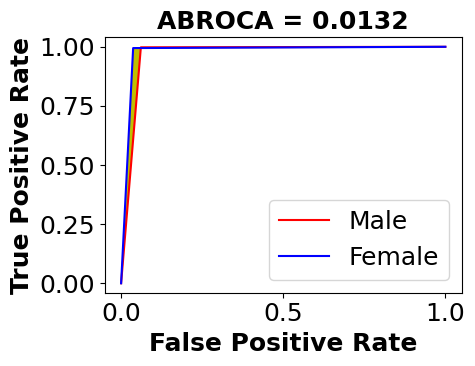

ABROCA: 0.013173101120510273


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='credit-scoring', algorithm='DT')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8785277760579231, 'accuracy': 0.9585078035782261, 'f1-score': 0.977229997911009, 'fairness': 0.04483669861356665}
Equal opportunity
{'balanced_accuracy': 0.8785277760579231, 'accuracy': 0.9585078035782261, 'f1-score': 0.977229997911009, 'fairness': 0.014894545261272762, 'TPR_protected': 0.9697377269670477, 'TPR_non_protected': 0.9846322722283205, 'TNR_protected': 0.8098159509202454, 'TNR_non_protected': 0.7121212121212122}
Equalized odds
{'balanced_accuracy': 0.8785277760579231, 'accuracy': 0.9585078035782261, 'f1-score': 0.977229997911009, 'fairness': 0.112589284060306, 'TPR_protected': 0.9697377269670477, 'TPR_non_protected': 0.9846322722283205, 'TNR_protected': 0.8098159509202454, 'TNR_non_protected': 0.7121212121212122}
Predictive parity
{'balanced_accuracy': 0.8785277760579231, 'accuracy': 0.9585078035782261, 'f1-s

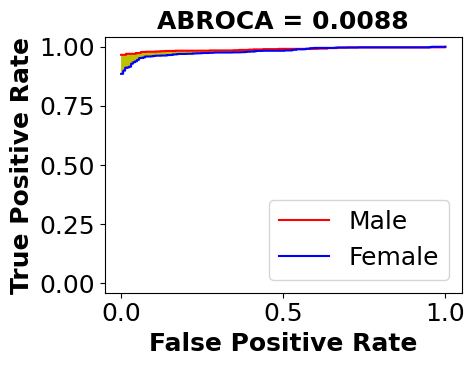

ABROCA: 0.00884640682084464


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='credit-scoring', algorithm='NB')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9922970743450692, 'accuracy': 0.9931480776551199, 'f1-score': 0.9962358845671268, 'fairness': 0.029941378989485457}
Equal opportunity
{'balanced_accuracy': 0.9922970743450692, 'accuracy': 0.9931480776551199, 'f1-score': 0.9962358845671268, 'fairness': 0.0001387805178727497, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.9934138309549945, 'TNR_protected': 0.9877300613496932, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.9922970743450692, 'accuracy': 0.9931480776551199, 'f1-score': 0.9962358845671268, 'fairness': 0.012408719168179538, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.9934138309549945, 'TNR_protected': 0.9877300613496932, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.9922970743450692, 'accuracy': 0.9931480776551199, 'f1-score': 0.9962358845671

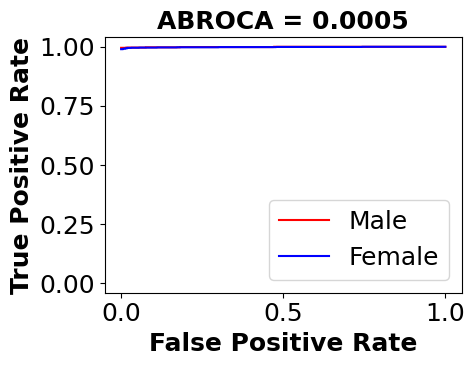

ABROCA: 0.0005258103323518725


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='credit-scoring', algorithm='MLP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8447459855556486, 'accuracy': 0.9581271412257327, 'f1-score': 0.9771784232365145, 'fairness': 0.04602152538692961}
Equal opportunity
{'balanced_accuracy': 0.8447459855556486, 'accuracy': 0.9581271412257327, 'f1-score': 0.9771784232365145, 'fairness': 0.023606713729010353, 'TPR_protected': 0.9731002017484869, 'TPR_non_protected': 0.9967069154774972, 'TNR_protected': 0.7177914110429447, 'TNR_non_protected': 0.6818181818181818}
Equalized odds
{'balanced_accuracy': 0.8447459855556486, 'accuracy': 0.9581271412257327, 'f1-score': 0.9771784232365145, 'fairness': 0.059579942953773335, 'TPR_protected': 0.9731002017484869, 'TPR_non_protected': 0.9967069154774972, 'TNR_protected': 0.7177914110429447, 'TNR_non_protected': 0.6818181818181818}
Predictive parity
{'balanced_accuracy': 0.8447459855556486, 'accuracy': 0.9581271412257327,

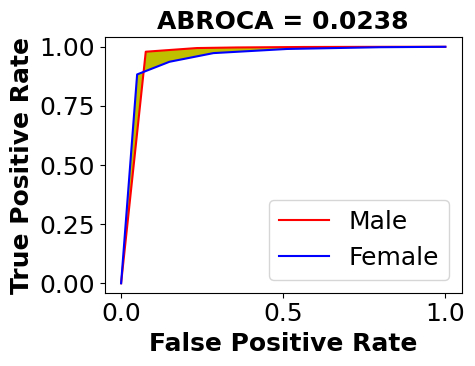

ABROCA: 0.023798801101833064


<Figure size 640x480 with 0 Axes>

In [8]:
run_eval(dataset='credit-scoring', algorithm='kNN')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9927140885235513, 'accuracy': 0.9939094023601066, 'f1-score': 0.9966555183946487, 'fairness': 0.03198846189634319}
Equal opportunity
{'balanced_accuracy': 0.9927140885235513, 'accuracy': 0.9939094023601066, 'f1-score': 0.9966555183946487, 'fairness': 0.0023341701995412967, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.995609220636663, 'TNR_protected': 0.9877300613496932, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.9927140885235513, 'accuracy': 0.9939094023601066, 'f1-score': 0.9966555183946487, 'fairness': 0.014604108849848085, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.995609220636663, 'TNR_protected': 0.9877300613496932, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.9927140885235513, 'accuracy': 0.9939094023601066, 'f1-score': 0.9966555183946487

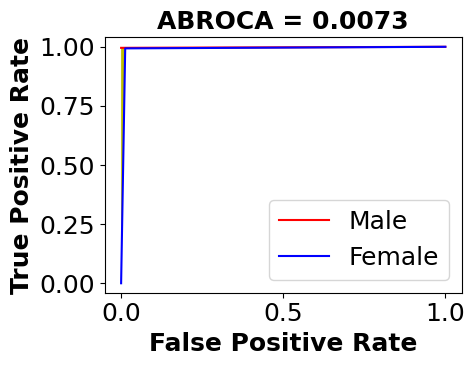

ABROCA: 0.007302141413460429


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='credit-scoring', algorithm='Ada')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9053541706880917, 'accuracy': 0.9642177388656262, 'f1-score': 0.9803264964420261, 'fairness': 0.04377283583015423}
Equal opportunity
{'balanced_accuracy': 0.9053541706880917, 'accuracy': 0.9642177388656262, 'f1-score': 0.9803264964420261, 'fairness': 0.019957819580897596, 'TPR_protected': 0.9690652320107599, 'TPR_non_protected': 0.9890230515916575, 'TNR_protected': 0.8343558282208589, 'TNR_non_protected': 0.8333333333333334}
Equalized odds
{'balanced_accuracy': 0.9053541706880917, 'accuracy': 0.9642177388656262, 'f1-score': 0.9803264964420261, 'fairness': 0.020980314468423078, 'TPR_protected': 0.9690652320107599, 'TPR_non_protected': 0.9890230515916575, 'TNR_protected': 0.8343558282208589, 'TNR_non_protected': 0.8333333333333334}
Predictive parity
{'balanced_accuracy': 0.9053541706880917, 'accuracy': 0.9642177388656262,

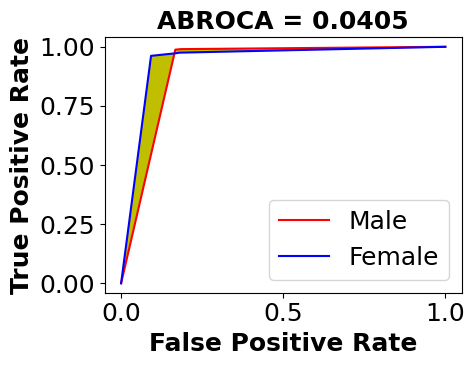

ABROCA: 0.04053104097514456


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval(dataset='credit-scoring', algorithm='Agar')

In [11]:
run_eval(dataset='credit-scoring', algorithm='DT', preprocessing_algorithm='DIR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9712970415666622, 'accuracy': 0.9908641035401599, 'f1-score': 0.9949958298582152, 'fairness': 0.03612294904004221}
Equal opportunity
{'balanced_accuracy': 0.9712970415666622, 'accuracy': 0.9908641035401599, 'f1-score': 0.9949958298582152, 'fairness': 0.0009891802869655963, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.995609220636663, 'TNR_protected': 0.9693251533742331, 'TNR_non_protected': 0.8939393939393939}
Equalized odds
{'balanced_accuracy': 0.9712970415666622, 'accuracy': 0.9908641035401599, 'f1-score': 0.9949958298582152, 'fairness': 0.07637493972180476, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.995609220636663, 'TNR_protected': 0.9693251533742331, 'TNR_non_protected': 0.8939393939393939}
Predictive parity
{'balanced_accuracy': 0.9712970415666622, 'accuracy': 0.9908641035401599, '

In [12]:
run_eval(dataset='credit-scoring', algorithm='NB', preprocessing_algorithm='DIR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9612176814011677, 'accuracy': 0.929196802436239, 'f1-score': 0.9596529284164859, 'fairness': 0.0934437517446729}
Equal opportunity
{'balanced_accuracy': 0.9612176814011677, 'accuracy': 0.929196802436239, 'f1-score': 0.9596529284164859, 'fairness': 0.07020817815875169, 'TPR_protected': 0.8957632817753867, 'TPR_non_protected': 0.9659714599341384, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.9612176814011677, 'accuracy': 0.929196802436239, 'f1-score': 0.9596529284164859, 'fairness': 0.07020817815875169, 'TPR_protected': 0.8957632817753867, 'TPR_non_protected': 0.9659714599341384, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.9612176814011677, 'accuracy': 0.929196802436239, 'f1-score': 0.9596529284164859, 'fairness': 0.0, 'TPR_protected': 

In [13]:
run_eval(dataset='credit-scoring', algorithm='MLP', preprocessing_algorithm='DIR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9820055650451067, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958246346555324, 'fairness': 0.02835209825997953}
Equal opportunity
{'balanced_accuracy': 0.9820055650451067, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958246346555324, 'fairness': 0.00010851455386862163, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9945115257958288, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9848484848484849}
Equalized odds
{'balanced_accuracy': 0.9820055650451067, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958246346555324, 'fairness': 0.02176681535327374, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9945115257958288, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9848484848484849}
Predictive parity
{'balanced_accuracy': 0.9820055650451067, 'accuracy': 0.9923867529501332

In [14]:
run_eval(dataset='credit-scoring', algorithm='kNN', preprocessing_algorithm='DIR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8377787530365552, 'accuracy': 0.9562238294632661, 'f1-score': 0.9761460277950633, 'fairness': 0.05030427095933743}
Equal opportunity
{'balanced_accuracy': 0.8377787530365552, 'accuracy': 0.9562238294632661, 'f1-score': 0.9761460277950633, 'fairness': 0.02672189343870801, 'TPR_protected': 0.9710827168796234, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.7116564417177914, 'TNR_non_protected': 0.6515151515151515}
Equalized odds
{'balanced_accuracy': 0.8377787530365552, 'accuracy': 0.9562238294632661, 'f1-score': 0.9761460277950633, 'fairness': 0.08686318364134793, 'TPR_protected': 0.9710827168796234, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.7116564417177914, 'TNR_non_protected': 0.6515151515151515}
Predictive parity
{'balanced_accuracy': 0.8377787530365552, 'accuracy': 0.9562238294632661, '

In [15]:
run_eval(dataset='credit-scoring', algorithm='DT', preprocessing_algorithm='LFR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5403320088428858, 'accuracy': 0.9143509706889988, 'f1-score': 0.9549007817197835, 'fairness': 0.008781365342266034}
Equal opportunity
{'balanced_accuracy': 0.5403320088428858, 'accuracy': 0.9143509706889988, 'f1-score': 0.9549007817197835, 'fairness': 0.005449349909238954, 'TPR_protected': 0.9912575655682583, 'TPR_non_protected': 0.9967069154774972, 'TNR_protected': 0.09202453987730061, 'TNR_non_protected': 0.07575757575757576}
Equalized odds
{'balanced_accuracy': 0.5403320088428858, 'accuracy': 0.9143509706889988, 'f1-score': 0.9549007817197835, 'fairness': 0.021716314028963804, 'TPR_protected': 0.9912575655682583, 'TPR_non_protected': 0.9967069154774972, 'TNR_protected': 0.09202453987730061, 'TNR_non_protected': 0.07575757575757576}
Predictive parity
{'balanced_accuracy': 0.5403320088428858, 'accuracy': 0.914350970688

In [17]:
run_eval(dataset='credit-scoring', algorithm='NB', preprocessing_algorithm='LFR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5055076828944062, 'accuracy': 0.9120669965740388, 'f1-score': 0.9539565477376918, 'fairness': -0.001669923389473027}
Equal opportunity
{'balanced_accuracy': 0.5055076828944062, 'accuracy': 0.9120669965740388, 'f1-score': 0.9539565477376918, 'fairness': 0.0015922849843170717, 'TPR_protected': 0.9973100201748487, 'TPR_non_protected': 0.9989023051591658, 'TNR_protected': 0.0, 'TNR_non_protected': 0.045454545454545456}
Equalized odds
{'balanced_accuracy': 0.5055076828944062, 'accuracy': 0.9120669965740388, 'f1-score': 0.9539565477376918, 'fairness': 0.04704683043886253, 'TPR_protected': 0.9973100201748487, 'TPR_non_protected': 0.9989023051591658, 'TNR_protected': 0.0, 'TNR_non_protected': 0.045454545454545456}
Predictive parity
{'balanced_accuracy': 0.5055076828944062, 'accuracy': 0.9120669965740388, 'f1-score': 0.953956547

In [18]:
run_eval(dataset='credit-scoring', algorithm='MLP', preprocessing_algorithm='LFR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.031234142861573777, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.912828

In [22]:
run_eval(dataset='credit-scoring', algorithm='kNN', preprocessing_algorithm='LFR')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5057161899836472, 'accuracy': 0.9124476589265321, 'f1-score': 0.9541650059784775, 'fairness': -0.002275983995533637}
Equal opportunity
{'balanced_accuracy': 0.5057161899836472, 'accuracy': 0.9124476589265321, 'f1-score': 0.9541650059784775, 'fairness': 0.0009197900280292215, 'TPR_protected': 0.9979825151311366, 'TPR_non_protected': 0.9989023051591658, 'TNR_protected': 0.0, 'TNR_non_protected': 0.045454545454545456}
Equalized odds
{'balanced_accuracy': 0.5057161899836472, 'accuracy': 0.9124476589265321, 'f1-score': 0.9541650059784775, 'fairness': 0.04637433548257468, 'TPR_protected': 0.9979825151311366, 'TPR_non_protected': 0.9989023051591658, 'TNR_protected': 0.0, 'TNR_non_protected': 0.045454545454545456}
Predictive parity
{'balanced_accuracy': 0.5057161899836472, 'accuracy': 0.9124476589265321, 'f1-score': 0.954165005

In [23]:
run_eval(dataset='credit-scoring', algorithm='DT', postprocessing_algorithm='EOP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.03449334698055273}
Equal opportunity
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.0031845699686340323, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9393939393939394}
Equalized odds
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.02698081462377433, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9393939393939394}
Predictive parity
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332,

In [24]:
run_eval(dataset='credit-scoring', algorithm='NB', postprocessing_algorithm='EOP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8598094846141799, 'accuracy': 0.9531785306433194, 'f1-score': 0.9743161411568179, 'fairness': 0.027328556806550663}
Equal opportunity
{'balanced_accuracy': 0.8598094846141799, 'accuracy': 0.9531785306433194, 'f1-score': 0.9743161411568179, 'fairness': 0.00122761702777896, 'TPR_protected': 0.972427706792199, 'TPR_non_protected': 0.973655323819978, 'TNR_protected': 0.7607361963190185, 'TNR_non_protected': 0.7121212121212122}
Equalized odds
{'balanced_accuracy': 0.8598094846141799, 'accuracy': 0.9531785306433194, 'f1-score': 0.9743161411568179, 'fairness': 0.04984260122558526, 'TPR_protected': 0.972427706792199, 'TPR_non_protected': 0.973655323819978, 'TNR_protected': 0.7607361963190185, 'TNR_non_protected': 0.7121212121212122}
Predictive parity
{'balanced_accuracy': 0.8598094846141799, 'accuracy': 0.9531785306433194, 'f1-

In [25]:
run_eval(dataset='credit-scoring', algorithm='MLP', postprocessing_algorithm='EOP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003, 'fairness': 0.029335318383424847}
Equal opportunity
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003, 'fairness': 0.0001387805178727497, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.9934138309549945, 'TNR_protected': 0.9815950920245399, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003, 'fairness': 0.018543688493332877, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.9934138309549945, 'TNR_protected': 0.9815950920245399, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003,

In [26]:
run_eval(dataset='credit-scoring', algorithm='kNN', postprocessing_algorithm='EOP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8317438840955527, 'accuracy': 0.9524172059383327, 'f1-score': 0.9740394600207686, 'fairness': 0.031126205762848635}
Equal opportunity
{'balanced_accuracy': 0.8317438840955527, 'accuracy': 0.9524172059383327, 'f1-score': 0.9740394600207686, 'fairness': 0.01262976532066784, 'TPR_protected': 0.9731002017484869, 'TPR_non_protected': 0.9857299670691547, 'TNR_protected': 0.6809815950920245, 'TNR_non_protected': 0.696969696969697}
Equalized odds
{'balanced_accuracy': 0.8317438840955527, 'accuracy': 0.9524172059383327, 'f1-score': 0.9740394600207686, 'fairness': 0.028617867198340363, 'TPR_protected': 0.9731002017484869, 'TPR_non_protected': 0.9857299670691547, 'TNR_protected': 0.6809815950920245, 'TNR_non_protected': 0.696969696969697}
Predictive parity
{'balanced_accuracy': 0.8317438840955527, 'accuracy': 0.9524172059383327, '

In [27]:
run_eval(dataset='credit-scoring', algorithm='DT', postprocessing_algorithm='CEP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.03449334698055273}
Equal opportunity
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.0031845699686340323, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9393939393939394}
Equalized odds
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332, 'f1-score': 0.9958298582151793, 'fairness': 0.02698081462377433, 'TPR_protected': 0.9946200403496974, 'TPR_non_protected': 0.9978046103183315, 'TNR_protected': 0.9631901840490797, 'TNR_non_protected': 0.9393939393939394}
Predictive parity
{'balanced_accuracy': 0.9760808679722185, 'accuracy': 0.9923867529501332,

In [28]:
run_eval(dataset='credit-scoring', algorithm='NB', postprocessing_algorithm='CEP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8616860484173492, 'accuracy': 0.9566044918157595, 'f1-score': 0.976240100041684, 'fairness': 0.05609565460128407}
Equal opportunity
{'balanced_accuracy': 0.8616860484173492, 'accuracy': 0.9566044918157595, 'f1-score': 0.976240100041684, 'fairness': 0.018187629783775527, 'TPR_protected': 0.9697377269670477, 'TPR_non_protected': 0.9879253567508233, 'TNR_protected': 0.8098159509202454, 'TNR_non_protected': 0.5909090909090909}
Equalized odds
{'balanced_accuracy': 0.8616860484173492, 'accuracy': 0.9566044918157595, 'f1-score': 0.976240100041684, 'fairness': 0.23709448979492997, 'TPR_protected': 0.9697377269670477, 'TPR_non_protected': 0.9879253567508233, 'TNR_protected': 0.8098159509202454, 'TNR_non_protected': 0.5909090909090909}
Predictive parity
{'balanced_accuracy': 0.8616860484173492, 'accuracy': 0.9566044918157595, 'f1

In [29]:
run_eval(dataset='credit-scoring', algorithm='MLP', postprocessing_algorithm='CEP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003, 'fairness': 0.030964920442914323}
Equal opportunity
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003, 'fairness': 0.0001387805178727497, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.9934138309549945, 'TNR_protected': 0.9877300613496932, 'TNR_non_protected': 0.9848484848484849}
Equalized odds
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 'f1-score': 0.996027597742003, 'fairness': 0.003020357019081099, 'TPR_protected': 0.9932750504371217, 'TPR_non_protected': 0.9934138309549945, 'TNR_protected': 0.9877300613496932, 'TNR_non_protected': 0.9848484848484849}
Predictive parity
{'balanced_accuracy': 0.9901136682315321, 'accuracy': 0.9927674153026266, 

In [30]:
run_eval(dataset='credit-scoring', algorithm='kNN', postprocessing_algorithm='CEP')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8229119244202774, 'accuracy': 0.9543205177007994, 'f1-score': 0.9751552795031055, 'fairness': 0.056256939921218274}
Equal opportunity
{'balanced_accuracy': 0.8229119244202774, 'accuracy': 0.9543205177007994, 'f1-score': 0.9751552795031055, 'fairness': 0.023606713729010353, 'TPR_protected': 0.9731002017484869, 'TPR_non_protected': 0.9967069154774972, 'TNR_protected': 0.7177914110429447, 'TNR_non_protected': 0.5303030303030303}
Equalized odds
{'balanced_accuracy': 0.8229119244202774, 'accuracy': 0.9543205177007994, 'f1-score': 0.9751552795031055, 'fairness': 0.21109509446892483, 'TPR_protected': 0.9731002017484869, 'TPR_non_protected': 0.9967069154774972, 'TNR_protected': 0.7177914110429447, 'TNR_non_protected': 0.5303030303030303}
Predictive parity
{'balanced_accuracy': 0.8229119244202774, 'accuracy': 0.9543205177007994,